In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import sys
import torchvision.transforms as transforms


In [46]:
class LeNet(nn.Module):
    # initial instances creates random weights by default
    def __init__(self):
        super(LeNet, self).__init__()
        linear = nn.Linear
        self.fc1 = linear(784, 300, bias=False)
        self.fc2 = linear(300, 100, bias=False)
        self.fc3 = linear(100, 10, bias=False)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = LeNet().to(device=device)
model.eval()
torch.save(model, 'LeNet.pt')


In [47]:
# Load model with paramaters
lenet = torch.load('LeNet.pt')
state_dict = lenet.state_dict()
# fc1_weight = np.array(state_dict['fc1.weight'])
# fc2_weight = np.array(state_dict['fc2.weight'])
# fc3_weight = np.array(state_dict['fc3.weight'])

fc1_weight = state_dict['fc1.weight'].cpu().numpy()
fc2_weight = state_dict['fc2.weight'].cpu().numpy()
fc3_weight = state_dict['fc3.weight'].cpu().numpy()

print(fc1_weight.shape)
print(fc2_weight.shape)
print(fc3_weight.shape)


(300, 784)
(100, 300)
(10, 100)


In [48]:
def log_softmax(vec):
    max_val = np.max(vec)
    exp = np.exp(vec - max_val)
    log_sum_exp = np.log(np.sum(exp))
    return vec - max_val - log_sum_exp

def normalize_array(vec):
    total = sum(vec)
    return np.apply_along_axis(lambda x: x/ total, axis=0, arr = vec)


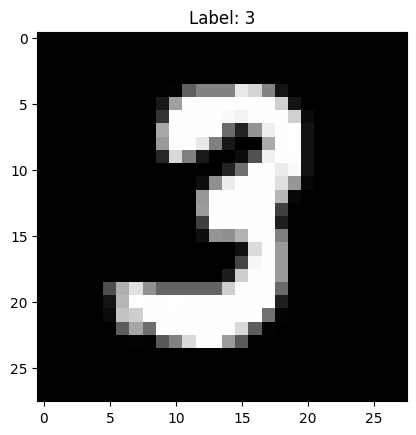

torch.Size([784])
(784,)


In [52]:
# get a test image
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_index = np.random.randint(0, x_train.shape[0])
image = x_train[image_index]
label = y_train[image_index]
plt.imshow(image, cmap='gray')
plt.title('Label: {}'.format(label))
plt.show()

# # my flatten and normalization
# flat_img = image.flatten()
# # print(flat_img)
# norm_flat_img = normalize_array(flat_img)
# # print(sum(norm_flat_img))
# print(norm_flat_img.size)

# proper flatten and normallization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) ])

img_tr = transform(image)
img_flat = torch.flatten(img_tr)
print(img_flat.shape)
img_np = np.array(img_flat)
print(img_np.shape)

In [53]:


l1 = img_np @ fc1_weight.T
relu_l1 = np.maximum(0, l1)

l2 = relu_l1 @ fc2_weight.T
relu_l2 = np.maximum(0, l2)

l3 = relu_l2 @ fc3_weight.T

soft_relu_l3 = log_softmax(l3)

probs = np.exp(soft_relu_l3)
sum_probs = np.sum(probs)
print(probs)
print(sum_probs)

print(np.argmax(probs))


[0.11190922 0.10818508 0.11075086 0.09193855 0.1077926  0.08943743
 0.07739162 0.09534439 0.10331666 0.10393351]
0.99999994
0
